# ORF recognition by CNN

In 105, we used Conv1D layers with filter width=3 with dropout to reduce overfitting. The simulated RNA lengths were 1000.

Here, try really short simulated RNA.


Added 4 layers.

In [14]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-18 13:47:52 UTC'

In [15]:
PC_SEQUENCES=2000   # how many protein-coding sequences
NC_SEQUENCES=2000   # how many non-coding sequences
PC_TESTS=2000
NC_TESTS=1000
RNA_LEN=91            # how long is each sequence
CDS_LEN=73
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 16   # how many different patterns the model looks for
NEURONS = 20
DROP_RATE = 0.2
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=30  # how many times to train on all the data
SPLITS=5  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=5  # train the model this many times (range 1 to SPLITS)

In [16]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import ORF_counter
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

On Google CoLab, mount cloud-local file, get our code from GitHub.


In [17]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import Flatten,MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [18]:
# Use code from our SimTools library.
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    tora = Transcript_Oracle()
    tora.set_cds_len_mean(CDS_LEN)  # CDS=ORF+STOP. 
    pcgen.set_seq_oracle(tora)
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(RNA_LEN)
pc_train = pc_sim.get_sequences(PC_SEQUENCES)
nc_train = nc_sim.get_sequences(NC_SEQUENCES)
print("Train on",len(pc_train),"PC seqs")
print("Train on",len(nc_train),"NC seqs")

Train on 2000 PC seqs
Train on 2000 NC seqs


In [19]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("PC train")
describe_sequences(pc_train)
print("NC train")
describe_sequences(nc_train)

PC train
Average RNA length: 91.0
Average ORF length: 68.907
NC train
Average RNA length: 91.0
Average ORF length: 12.3195


In [20]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [21]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Conv1D(filters=FILTERS, kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Conv1D(filters=FILTERS, kernel_size=WIDTH,strides=STRIDE, padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Conv1D(filters=FILTERS, kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Conv1D(filters=FILTERS, kernel_size=WIDTH, strides=STRIDE, padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Flatten())
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (91, 4)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 91, 16)            208       
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 91, 16)            784       
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 45, 16)            0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 45, 16)            784       
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 22, 16)            0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 22, 16)            784       
_________________________________________________________________
max_pooling1d_38 (MaxPoo

In [22]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (91, 4)
FIT
Epoch 1/30
100/100 [==============================] - 3s 16ms/step - loss: 0.7136 - accuracy: 0.4956 - val_loss: 0.6830 - val_accuracy: 0.6288
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/30
100/100 [==============================] - 1s 10ms/step - loss: 0.6838 - accuracy: 0.5439 - val_loss: 0.5789 - val_accuracy: 0.7175
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 3/30
100/100 [==============================] - 1s 10ms/step - loss: 0.5589 - accuracy: 0.7202 - val_loss: 0.4730 - val_accuracy: 0.7887
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 4/30
100/100 [==============================] - 1s 11ms/step - loss: 0.4627 - accuracy: 0.7964 - val_loss: 0.4599 - val_accuracy: 0.8000
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 5/30
100/100 [==============================] - 1s 10ms/step - loss: 0.3955 - accuracy: 0.8325 - val_loss: 0.4001 - val_accuracy: 0.8338
INFO:tensorflow:Assets written to: Be

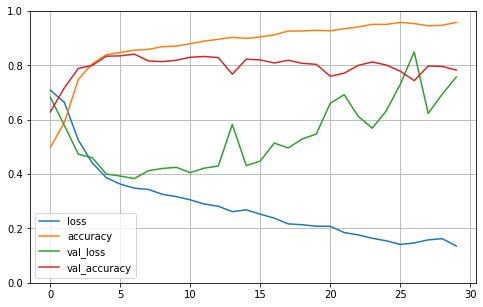

MODEL
make_DNN
input shape: (91, 4)
FIT
Epoch 1/30
100/100 [==============================] - 3s 16ms/step - loss: 0.7084 - accuracy: 0.4949 - val_loss: 0.6930 - val_accuracy: 0.4900
Epoch 2/30
100/100 [==============================] - 1s 10ms/step - loss: 0.6928 - accuracy: 0.5348 - val_loss: 0.6473 - val_accuracy: 0.6413
Epoch 3/30
100/100 [==============================] - 1s 11ms/step - loss: 0.6198 - accuracy: 0.6749 - val_loss: 0.5315 - val_accuracy: 0.7475
Epoch 4/30
100/100 [==============================] - 1s 10ms/step - loss: 0.4978 - accuracy: 0.7778 - val_loss: 0.4409 - val_accuracy: 0.8012
Epoch 5/30
100/100 [==============================] - 1s 10ms/step - loss: 0.4049 - accuracy: 0.8249 - val_loss: 0.5020 - val_accuracy: 0.7788
Epoch 6/30
100/100 [==============================] - 1s 10ms/step - loss: 0.3820 - accuracy: 0.8493 - val_loss: 0.3999 - val_accuracy: 0.8250
Epoch 7/30
100/100 [==============================] - 1s 10ms/step - loss: 0.3479 - accuracy: 0.8606 -

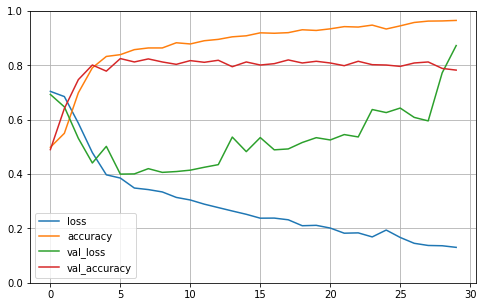

MODEL
make_DNN
input shape: (91, 4)
FIT
Epoch 1/30
100/100 [==============================] - 3s 17ms/step - loss: 0.7245 - accuracy: 0.5024 - val_loss: 0.6947 - val_accuracy: 0.5063
Epoch 2/30
100/100 [==============================] - 1s 11ms/step - loss: 0.7020 - accuracy: 0.4799 - val_loss: 0.6917 - val_accuracy: 0.5238
Epoch 3/30
100/100 [==============================] - 1s 11ms/step - loss: 0.6917 - accuracy: 0.5371 - val_loss: 0.6829 - val_accuracy: 0.5700
Epoch 4/30
100/100 [==============================] - 1s 10ms/step - loss: 0.6753 - accuracy: 0.5771 - val_loss: 0.6506 - val_accuracy: 0.6338
Epoch 5/30
100/100 [==============================] - 1s 11ms/step - loss: 0.6315 - accuracy: 0.6546 - val_loss: 0.5744 - val_accuracy: 0.7325
Epoch 6/30
100/100 [==============================] - 1s 10ms/step - loss: 0.5201 - accuracy: 0.7629 - val_loss: 0.4594 - val_accuracy: 0.7975
Epoch 7/30
100/100 [==============================] - 1s 10ms/step - loss: 0.4424 - accuracy: 0.8202 -

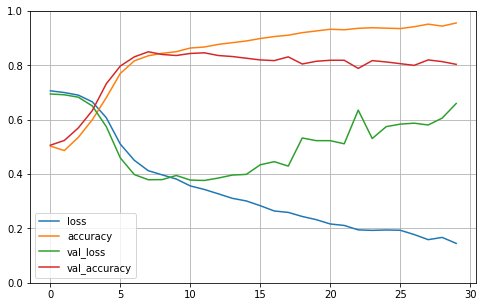

MODEL
make_DNN
input shape: (91, 4)
FIT
Epoch 1/30
100/100 [==============================] - 3s 16ms/step - loss: 0.7043 - accuracy: 0.5091 - val_loss: 0.6712 - val_accuracy: 0.6087
Epoch 2/30
100/100 [==============================] - 1s 10ms/step - loss: 0.6400 - accuracy: 0.6429 - val_loss: 0.5384 - val_accuracy: 0.7525
Epoch 3/30
100/100 [==============================] - 1s 11ms/step - loss: 0.4873 - accuracy: 0.7847 - val_loss: 0.4338 - val_accuracy: 0.8075
Epoch 4/30
100/100 [==============================] - 1s 11ms/step - loss: 0.3969 - accuracy: 0.8404 - val_loss: 0.4115 - val_accuracy: 0.8263
Epoch 5/30
100/100 [==============================] - 1s 10ms/step - loss: 0.3639 - accuracy: 0.8511 - val_loss: 0.4133 - val_accuracy: 0.8163
Epoch 6/30
100/100 [==============================] - 1s 10ms/step - loss: 0.3552 - accuracy: 0.8547 - val_loss: 0.4097 - val_accuracy: 0.8250
Epoch 7/30
100/100 [==============================] - 1s 10ms/step - loss: 0.3377 - accuracy: 0.8662 -

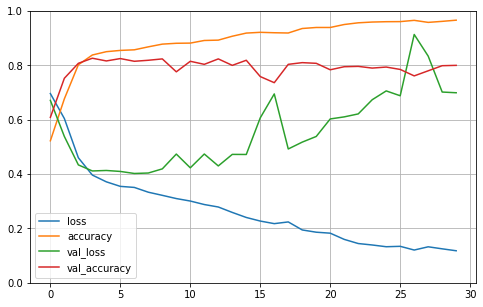

MODEL
make_DNN
input shape: (91, 4)
FIT
Epoch 1/30
100/100 [==============================] - 4s 18ms/step - loss: 0.7053 - accuracy: 0.5030 - val_loss: 0.6841 - val_accuracy: 0.5612
Epoch 2/30
100/100 [==============================] - 1s 11ms/step - loss: 0.6904 - accuracy: 0.5401 - val_loss: 0.6679 - val_accuracy: 0.5775
Epoch 3/30
100/100 [==============================] - 1s 11ms/step - loss: 0.6587 - accuracy: 0.6130 - val_loss: 0.6264 - val_accuracy: 0.6488
Epoch 4/30
100/100 [==============================] - 1s 12ms/step - loss: 0.5957 - accuracy: 0.6921 - val_loss: 0.5334 - val_accuracy: 0.7563
Epoch 5/30
100/100 [==============================] - 1s 11ms/step - loss: 0.4951 - accuracy: 0.7795 - val_loss: 0.4404 - val_accuracy: 0.8125
Epoch 6/30
100/100 [==============================] - 1s 11ms/step - loss: 0.4089 - accuracy: 0.8387 - val_loss: 0.4169 - val_accuracy: 0.8200
Epoch 7/30
100/100 [==============================] - 1s 11ms/step - loss: 0.3761 - accuracy: 0.8539 -

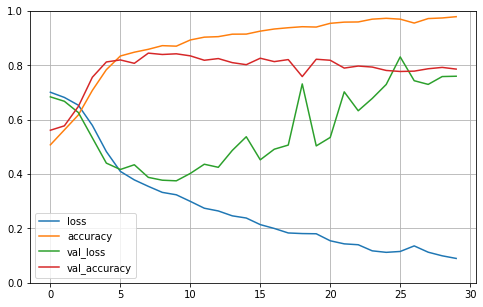

In [23]:
do_cross_validation(X,y)

In [24]:
from keras.models import load_model
pc_sim.set_reproducible(True)
nc_sim.set_reproducible(True)
pc_test = pc_sim.get_sequences(PC_TESTS)
nc_test = nc_sim.get_sequences(NC_TESTS)
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 2000 PC seqs
Test on 1000 NC seqs
accuracy: 85.17%


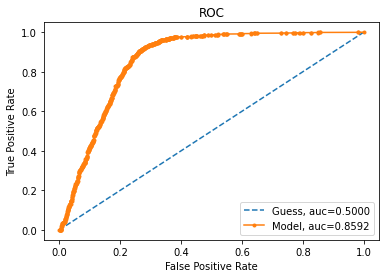

AUC: 85.92%


In [25]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [26]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-18 13:51:59 UTC'

## Conclusion
The CNN is very capable of learning ORF/nonORF from simulated short RNA.